In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models
import models_3d_concepts_on_time
import models_3d_atomics_on_variate_to_concepts
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

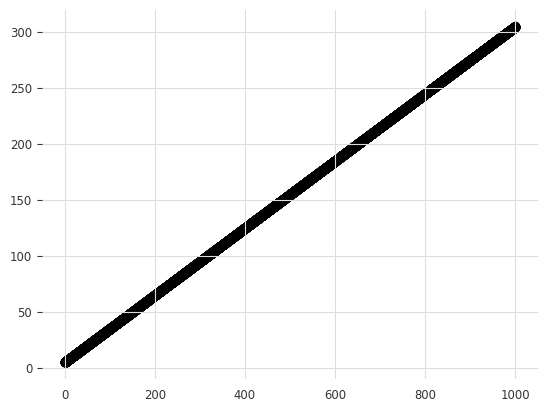

In [2]:

def line(x, w=0.3, b=5):
    return w*x + b

time = np.linspace(0, 1000, 10000).reshape(-1,1)

line_series = [line(x) for x in time]
line_series = np.array(line_series).reshape(-1,1)

plt.scatter(time, line_series)
plt.show()

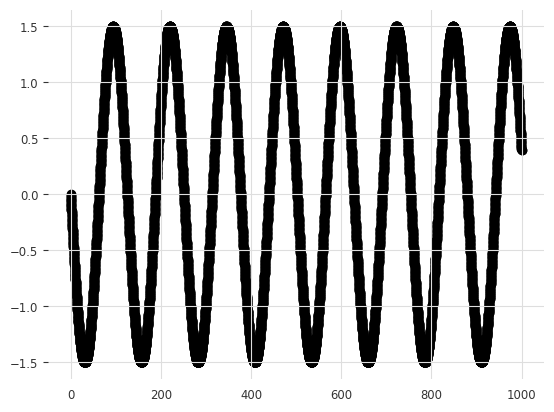

In [3]:

def sine_wave(time, frequency = 1, amplitude = 1, phase = 0):
    return amplitude * np.sin(frequency * time + phase)

sine_series = sine_wave(time, frequency = 0.05, amplitude = 1.5, phase = np.pi)

plt.scatter(time, sine_series)
plt.show()

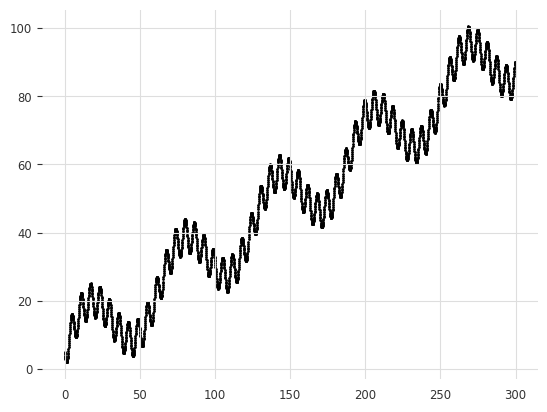

In [4]:

components_series = sine_wave(time, frequency = 1, amplitude = 5, phase = np.pi) \
                + sine_wave(time, frequency = 0.1, amplitude = 10, phase = 0) \
                + line_series

plt.scatter(time[:3000], components_series[:3000], s=1)
plt.show()

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [6]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train_end = int(len(series) * 0.6)
    val_end = int(train_end + len(series) * 0.2)
    
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]
    
    # train, test = series.split_before(0.6)
    # val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train = scaler.fit_transform(train)
    X_train = pd.DataFrame(train)
    y_train = X_train
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val = scaler.transform(val)
    X_val = pd.DataFrame(val)
    y_val = X_val
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test = scaler.transform(test)
    X_test = pd.DataFrame(test)
    y_test = X_test
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


Train/Val/Test 6000 2000 2000


torch.Size([512, 100, 2]) False
torch.Size([512, 10]) False


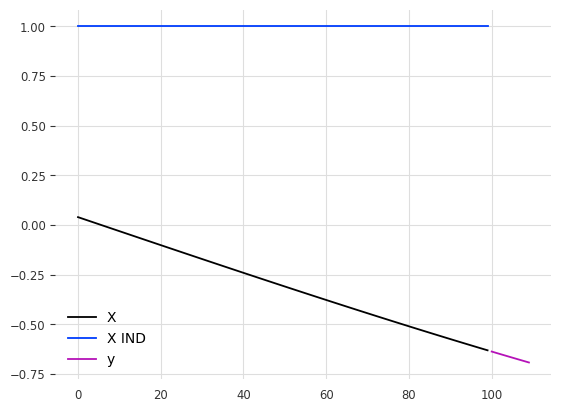

Batches 12 4 4


In [7]:
seq_len = 100
pred_len = 10

train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

for X,y in train_loader:
    print(X.shape, X.requires_grad)
    print(y.shape, X.requires_grad)
    break

i = 0
plt.plot(range(seq_len), X[i, :, 0], label="X")
plt.plot(range(seq_len), X[i, :, 1], label="X IND")
plt.plot(range(seq_len, seq_len + pred_len), y[i], label="y")
plt.legend()
plt.show()


print("Batches", len(train_loader), len(val_loader), len(test_loader))


In [8]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(yb, preds, title):
    plt.plot(yb, color="black", label="True")
    plt.plot(preds, color="red", label="Pred")
    plt.title(title)
    plt.legend()
    plt.show()


In [45]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, top_k=''):
    model = models_3d_atomics_on_variate_to_concepts.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics = n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_3d_atomics_on_variate_to_concepts.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [10]:
random_seed = 1
set_seed(random_seed)


In [11]:
seq_len = 10
pred_len = 10
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = 1 #len(series.columns)
input_dim = 2 * changing_dim


## Blaaa

In [12]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/debugging-L{seq_len}-T{pred_len}/"
# model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 6000 2000 2000
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/debugging-L10-T10/forecasting_cline_atomics.pt


 25%|██▍       | 2479/9960 [13:01<39:19,  3.17it/s] 

Early Stopped


MSE 0.00023092991614248604 MAE 0.0077482545748353004
(10, 1)
(10, 1)


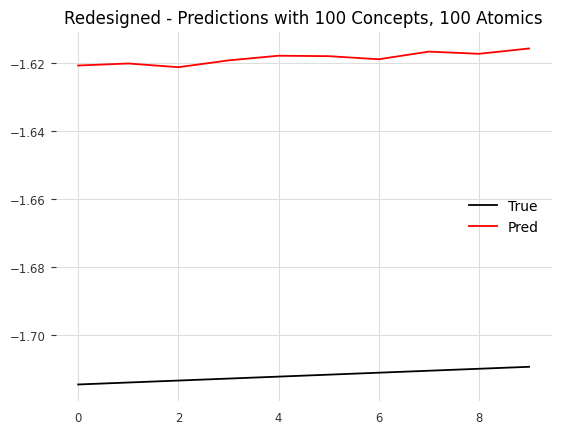

,0
-1.620664,-1.714442
-1.620068,-1.713864
-1.621158,-1.713287
-1.619167,-1.712710
-1.617783,-1.712132
-1.617915,-1.711555
-1.618826,-1.710978
-1.616578,-1.710400
-1.617224,-1.709823
-1.615656,-1.709245


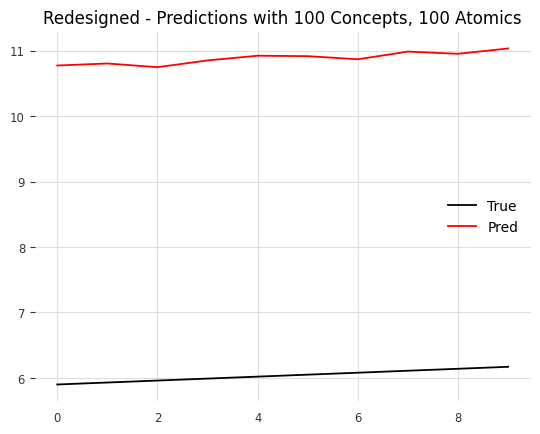

,0
10.773403,5.900089
10.804356,5.930088
10.747715,5.960094
10.851223,5.990101
10.923107,6.020107
10.916256,6.050106
10.868916,6.080105
10.985760,6.110111
10.952168,6.140110
11.033665,6.170116


In [15]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(line_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("line_atomics"), max_epochs=10000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


Train/Val/Test 6000 2000 2000


  0%|          | 8/10000 [00:02<50:51,  3.27it/s]

100%|██████████| 10000/10000 [52:31<00:00,  3.17it/s]


MSE 0.0005682552582584321 MAE 0.017997918650507927
(10, 1)
(10, 1)


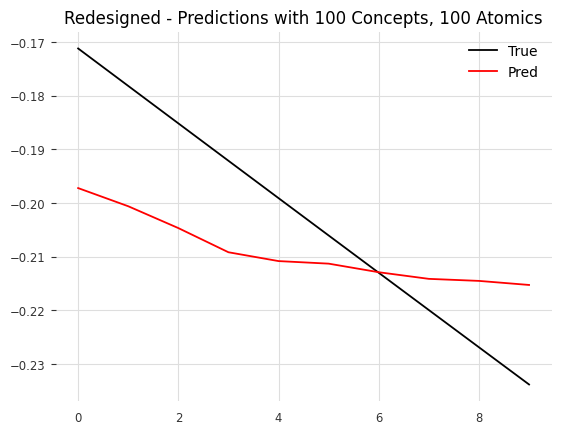

,0
-0.197230,-0.171224
-0.200613,-0.178202
-0.204680,-0.185174
-0.209182,-0.192141
-0.210828,-0.199101
-0.211305,-0.206056
-0.212904,-0.213005
-0.214138,-0.219947
-0.214518,-0.226883
-0.215274,-0.233813


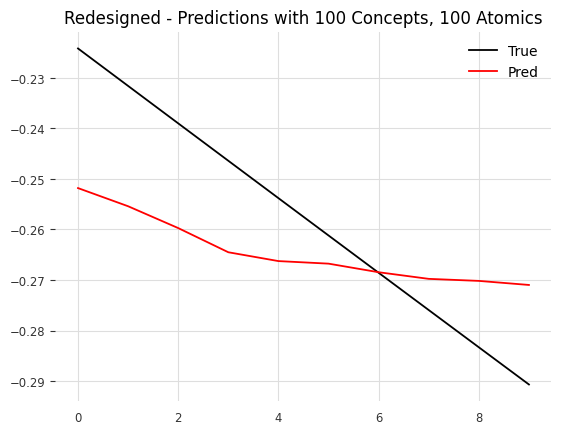

,0
-0.251810,-0.224179
-0.255405,-0.231593
-0.259726,-0.239001
-0.264509,-0.246403
-0.266257,-0.253799
-0.266764,-0.261188
-0.268464,-0.268571
-0.269775,-0.275947
-0.270178,-0.283316
-0.270982,-0.290679


In [16]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("sine"), max_epochs=10000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


In [17]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("components_series"), max_epochs=10000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 0
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


Train/Val/Test 6000 2000 2000


  0%|          | 2/10000 [00:00<52:14,  3.19it/s]

 15%|█▌        | 1504/10000 [07:55<45:28,  3.11it/s] 

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train/Val/Test 6000 2000 2000
CBM(
  (sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=32, out_features=100, bias=True)
  (linear): LazyLinear(in_features=0, out_features=10, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

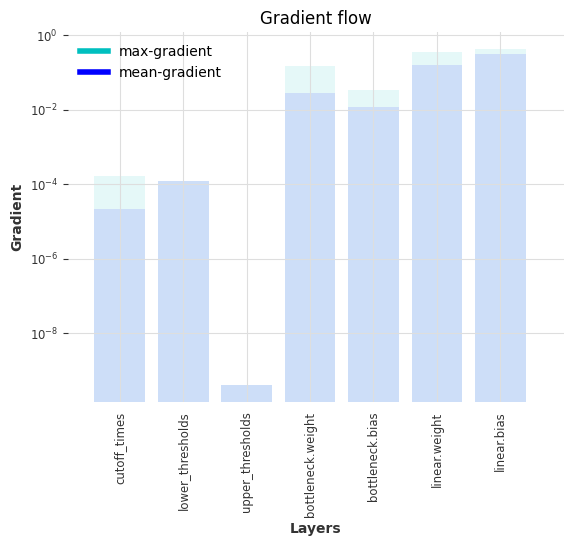

  0%|          | 0/20 [00:00<?, ?it/s]

Parameter: cutoff_times, Gradient: tensor([[-2.6896e-06,  1.4667e-05,  7.2424e-09, -3.4831e-06,  0.0000e+00,
         -2.8475e-08,  1.6716e-04, -1.3681e-13,  1.4367e-06]], device='cuda:0',
       dtype=torch.float64)
Parameter: lower_thresholds, Gradient: tensor([-0.0001], device='cuda:0', dtype=torch.float64)
Parameter: upper_thresholds, Gradient: tensor([-4.0728e-10], device='cuda:0', dtype=torch.float64)
Parameter: bottleneck.weight, Gradient: tensor([[-3.3538e-03,  3.8301e-02,  2.2945e-02,  ...,  1.6748e-02,
         -5.6470e-03, -2.6028e-02],
        [ 1.9525e-02, -3.6790e-03, -4.7600e-03,  ...,  6.1377e-03,
          8.4557e-03,  1.7155e-02],
        [ 6.9906e-03,  1.4457e-04, -5.3430e-02,  ..., -2.5932e-02,
         -9.8201e-04,  4.0168e-02],
        ...,
        [ 3.6397e-02,  1.9068e-02,  7.6145e-03,  ..., -2.9461e-03,
          3.6783e-02,  4.5266e-03],
        [-1.8774e-02, -7.7382e-03, -3.5941e-02,  ..., -2.3953e-02,
         -1.9618e-02, -3.1433e-02],
        [ 1.4352e-02,

In [66]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

n_concepts = 100
n_atomics = 100

# model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

print(model)
# print(model.named_parameters)

# for name, param in model.named_parameters():
#     print(name, param.shape, param.requires_grad, param.device, param.dtype)
#     if param.grad is not None:
#         print(f"Parameter: {name}, Gradient: {param}")


model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=20, patience=1, show_grad=True)


In [67]:
from graphviz import Source
path = 'aDebugGraph.dot'
s = Source.from_file(path)
s.render('aDebugGraph', format='svg', cleanup=True)

'aDebugGraph.svg'